## Install Torch and TorchVision

In [13]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


# PyTorch MNIST Project

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 1. Load & Preprocess Data


In [18]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_set, val_set = random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=1000)

## 2. Define Model


In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 3. Training Loop


In [22]:
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(5):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (output.argmax(1) == labels).sum().item()
    train_losses.append(total_loss / len(train_loader))
    train_accs.append(100 * correct / len(train_set))

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            output = model(images)
            val_loss += criterion(output, labels).item()
            val_correct += (output.argmax(1) == labels).sum().item()
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(100 * val_correct / len(val_set))
    
    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f}, Acc: {val_accs[-1]:.2f}%")


Epoch 1 | Train Loss: 0.3849, Acc: 89.15% | Val Loss: 0.2098, Acc: 93.91%
Epoch 2 | Train Loss: 0.1602, Acc: 95.26% | Val Loss: 0.1412, Acc: 95.81%
Epoch 3 | Train Loss: 0.1116, Acc: 96.54% | Val Loss: 0.1182, Acc: 96.42%
Epoch 4 | Train Loss: 0.0819, Acc: 97.48% | Val Loss: 0.1021, Acc: 96.87%
Epoch 5 | Train Loss: 0.0656, Acc: 97.91% | Val Loss: 0.1005, Acc: 96.97%


## 4. Plot Loss and Accuracy


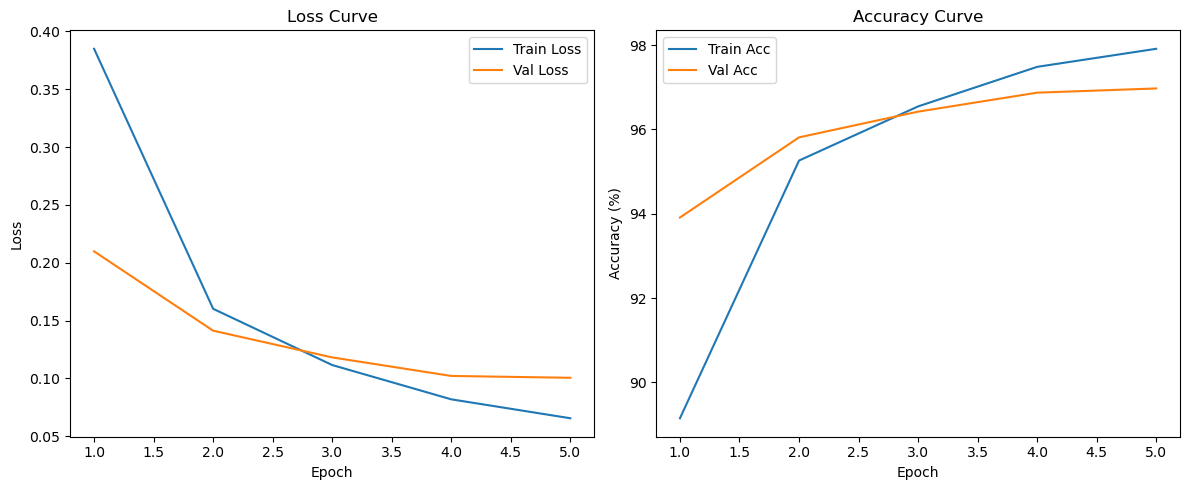

In [24]:
epochs = range(1, 6)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

## 5. Evaluate on Test Set


In [26]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Accuracy
correct = np.sum(np.array(all_preds) == np.array(all_labels))
total = len(all_labels)
print(f"\nTest Accuracy: {100 * correct / total:.2f}%")


✅ Test Accuracy: 97.50%


## 6. Show Predictions on Sample Images

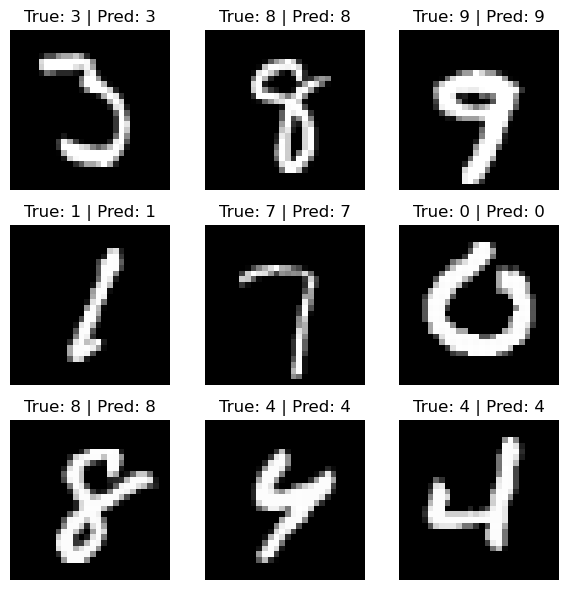

In [28]:
import random
idxs = random.sample(range(len(test_set)), 9)
fig, axs = plt.subplots(3, 3, figsize=(6, 6))
for i, idx in enumerate(idxs):
    image, label = test_set[idx]
    with torch.no_grad():
        pred = model(image.unsqueeze(0)).argmax().item()
    axs[i//3][i%3].imshow(image.squeeze(), cmap='gray')
    axs[i//3][i%3].set_title(f'True: {label} | Pred: {pred}')
    axs[i//3][i%3].axis('off')
plt.tight_layout()
plt.show()

## 7. Confusion Matrix


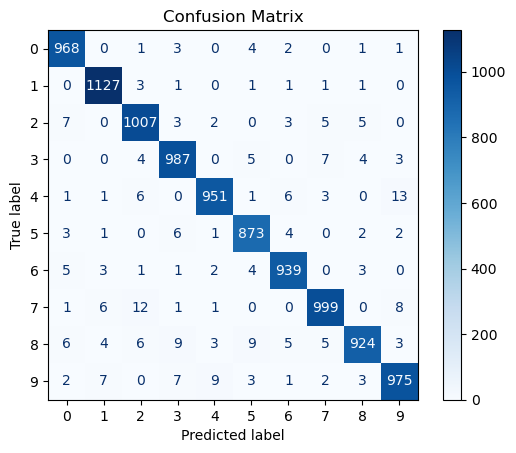

In [30]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
